In [ ]:
#эксперименты с ансамблем: 

In [1]:
!pip -q install transformers datasets accelerate evaluate scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Установка и импорт

import os, json, math, numpy as np, pandas as pd
from dataclasses import dataclass
from collections import Counter
from typing import Optional, Dict, List

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          DataCollatorWithPadding, TrainingArguments, Trainer)
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

2025-09-30 16:34:13.472076: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759250053.847875      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759250053.947883      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Проверяем подключение к гпу

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Sep 30 16:34:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8             11W /   70W |       3MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
df_train = pd.read_csv('/kaggle/input/category-task/train.tsv', sep='\t')

print("Пример данных:")
df_train

Пример данных:


,app_name,full_description,shortDescription,labels_str
0,Матрона Московская.,Хочешь знать что будет? Загляни в будущие. Мат...,Узнать будущее. Предсказания . Магия волшебног...,lifestyle
1,"Run and Jump - ""Бесконечный раннер""",Run and Jump это новая увлекательная Аркада - ...,Платформенная Аркада - Раннер с захватывающим ...,action|arcade
2,Ghost Maze,"Играя за приведение, собирай необходимые комби...",Игра-головоломка. Попробуй найти выход из лаби...,arcade|puzzle
3,LabTools Mobile: ЛАБОРАТОРНЫЕ ПРИБОРЫ,AR-приложение «LabTools Mobile: Лабораторные п...,AR-приложение которое предназначено для изучен...,education
4,Mario Anime Coloring,\nРаскрасьте своих любимых персонажей из mario...,Раскрасьте своих любимых персонажей из mario я...,children|family
...,...,...,...,...
53489,Yota: мобильная связь,﻿С Yota можно всё!\n\nМожно не беспокоиться – ...,Управляй тарифом и услугами,tools
53490,BTS Musical Player,"Высококачественный музыкальный плеер BTS, мощн...",Музыкальный плеер BTS,tools
53491,Lite Calculator,Lite Calculator - это простое и удобное прилож...,Базовые операции калькулятора,tools
53492,Optiland,Приложение Optiland - многофункциональный серв...,"Для жителей поселков Бристоль, Марсель и Кембридж",tools


In [6]:
# Склеиваем текст (название + короткое + полное описание)

def build_text(row):
    parts = [
        str(row.get("app_name") or ""),
        str(row.get("shortDescription") or ""),
        str(row.get("full_description") or ""),
    ]
    txt = " ".join(p.strip() for p in parts if p).strip()
    return " ".join(txt.split())  # нормализуем пробелы

df_train["text"] = df_train.apply(build_text, axis=1)

In [7]:
df_train["text"]

0        Матрона Московская. Узнать будущее. Предсказан...
1        Run and Jump - "Бесконечный раннер" Платформен...
2        Ghost Maze Игра-головоломка. Попробуй найти вы...
3        LabTools Mobile: ЛАБОРАТОРНЫЕ ПРИБОРЫ AR-прило...
4        Mario Anime Coloring Раскрасьте своих любимых ...
                               ...                        
53489    Yota: мобильная связь Управляй тарифом и услуг...
53490    BTS Musical Player Музыкальный плеер BTS Высок...
53491    Lite Calculator Базовые операции калькулятора ...
53492    Optiland Для жителей поселков Бристоль, Марсел...
53493    SelfiShop Camera Камера для селфи моноподов Сд...
Name: text, Length: 53494, dtype: object

In [8]:
expected_cols = {"app_name", "full_description", "shortDescription", "labels_str"}

def parse_labels(s):

    """Преобразует строку вида 'cat1|cat2' в список ['cat1', 'cat2']"""

    if pd.isna(s):
       return []
    return [t.strip() for t in str(s).split("|") if t.strip()]

df_train["labels_list"] = df_train["labels_str"].apply(parse_labels)
df_train["n_labels"] = df_train["labels_list"].apply(len)
all_labels = [label for labels in df_train["labels_list"] for label in labels]
label_counts = Counter(all_labels) # сколько раз встречается каждая уникальная метка

labels_df = (pd.DataFrame({"Категория": list(label_counts.keys()), "Количество": list(label_counts.values())})
             .sort_values("Количество", ascending=False)
             .reset_index(drop=True))
labels_df["Доля_%"] = (labels_df["Количество"] / len(df_train) * 100).round(2)
card_df = (df_train["n_labels"].value_counts().sort_index()
           .rename_axis("Категорий на приложение").reset_index(name="Количество приложений"))
card_df["Доля_%"] = (card_df["Количество приложений"] / len(df_train) * 100).round(2)

print(f"Всего приложений в датасете: {len(df_train)}")
print(f"Всего уникальных категорий: {labels_df.shape[0]}")
print(f"Среднее число категорий на приложение: {df_train['n_labels'].mean():.2f}")

Всего приложений в датасете: 53494
Всего уникальных категорий: 45
Среднее число категорий на приложение: 1.19


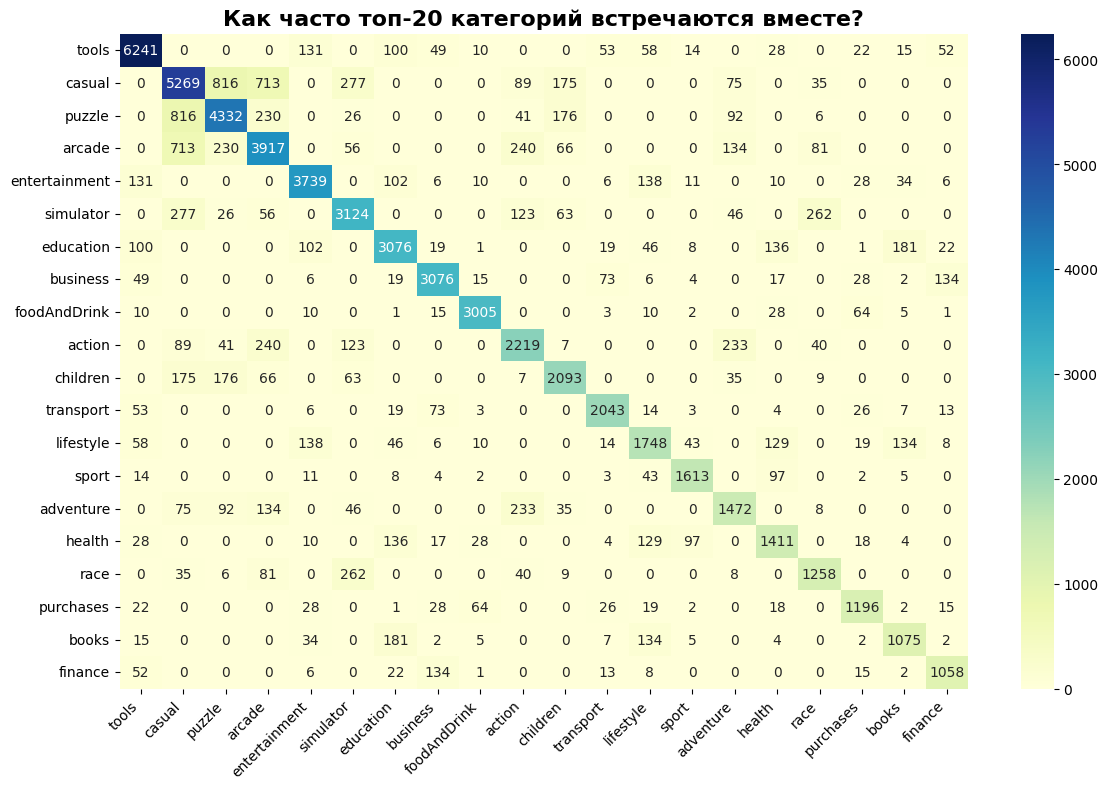

In [12]:
# Еще давайте глянем на совместную встречаемость лейблов (Co-occurrence Matrix)

TOPN = 20 # Возьмем топ-20 категорий для наглядности
topN_labels = labels_df["Категория"].head(TOPN).tolist()
label_to_idx = {label: i for i, label in enumerate(topN_labels)}

co_occurrence_matrix = np.zeros((TOPN, TOPN), dtype=int)

for labels in df_train["labels_list"]:
    # Фильтруем метки, оставляя только те, что входят в наш топ
    top_labels_in_app = [l for l in labels if l in label_to_idx]
    # Проходим по всем парам меток в одном приложении
    for i in range(len(top_labels_in_app)):
        for j in range(i, len(top_labels_in_app)):
            idx1 = label_to_idx[top_labels_in_app[i]]
            idx2 = label_to_idx[top_labels_in_app[j]]
            co_occurrence_matrix[idx1, idx2] += 1
            # Матрица симметрична, поэтому заполняем и вторую половину
            if idx1 != idx2:
                co_occurrence_matrix[idx2, idx1] += 1

plt.figure(figsize=(12, 8))
sns.heatmap(co_occurrence_matrix, annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=topN_labels, yticklabels=topN_labels)
plt.title(f"Как часто топ-{TOPN} категорий встречаются вместе?", fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [9]:
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(df_train["labels_list"])
labels = mlb.classes_.tolist()
NUM_LABELS = len(labels)

with open("labels.json", "w", encoding="utf-8") as f:
    json.dump(labels, f, ensure_ascii=False, indent=2)

print("Число меток:", NUM_LABELS)
print("Пример меток:", labels[:10])

Число меток: 45
Пример меток: ['action', 'adsAndServices', 'adventure', 'ar', 'arcade', 'board', 'boardAndCard', 'books', 'business', 'card']


In [10]:
from gensim.scripts.glove2word2vec import glove2word2vec
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip
!cd glove.6B/

--2025-09-30 16:38:16--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-09-30 16:38:16--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-09-30 16:38:17--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [11]:
from gensim.scripts.glove2word2vec import glove2word2vec

glove_input_file = 'glove.6B.100d.txt'
word2vec_output_file = 'glove.6B.100d.txt.word2vec'

glove2word2vec(glove_input_file, word2vec_output_file)

/tmp/ipykernel_36/1040684936.py:6: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


(400000, 100)

In [12]:
from gensim.models import KeyedVectors
import re

model = KeyedVectors.load_word2vec_format(word2vec_output_file)  # загрузка конвертированной модели

In [14]:
df_train

,app_name,full_description,shortDescription,labels_str,text,labels_list,n_labels
0,Матрона Московская.,Хочешь знать что будет? Загляни в будущие. Мат...,Узнать будущее. Предсказания . Магия волшебног...,lifestyle,Матрона Московская. Узнать будущее. Предсказан...,[lifestyle],1
1,"Run and Jump - ""Бесконечный раннер""",Run and Jump это новая увлекательная Аркада - ...,Платформенная Аркада - Раннер с захватывающим ...,action|arcade,"Run and Jump - ""Бесконечный раннер"" Платформен...","[action, arcade]",2
2,Ghost Maze,"Играя за приведение, собирай необходимые комби...",Игра-головоломка. Попробуй найти выход из лаби...,arcade|puzzle,Ghost Maze Игра-головоломка. Попробуй найти вы...,"[arcade, puzzle]",2
3,LabTools Mobile: ЛАБОРАТОРНЫЕ ПРИБОРЫ,AR-приложение «LabTools Mobile: Лабораторные п...,AR-приложение которое предназначено для изучен...,education,LabTools Mobile: ЛАБОРАТОРНЫЕ ПРИБОРЫ AR-прило...,[education],1
4,Mario Anime Coloring,\nРаскрасьте своих любимых персонажей из mario...,Раскрасьте своих любимых персонажей из mario я...,children|family,Mario Anime Coloring Раскрасьте своих любимых ...,"[children, family]",2
...,...,...,...,...,...,...,...
53489,Yota: мобильная связь,﻿С Yota можно всё!\n\nМожно не беспокоиться – ...,Управляй тарифом и услугами,tools,Yota: мобильная связь Управляй тарифом и услуг...,[tools],1
53490,BTS Musical Player,"Высококачественный музыкальный плеер BTS, мощн...",Музыкальный плеер BTS,tools,BTS Musical Player Музыкальный плеер BTS Высок...,[tools],1
53491,Lite Calculator,Lite Calculator - это простое и удобное прилож...,Базовые операции калькулятора,tools,Lite Calculator Базовые операции калькулятора ...,[tools],1
53492,Optiland,Приложение Optiland - многофункциональный серв...,"Для жителей поселков Бристоль, Марсель и Кембридж",tools,"Optiland Для жителей поселков Бристоль, Марсел...",[tools],1


In [15]:
train_for_glove = df_train['text'].apply(lambda x: x.split())
train_for_glove

0        [Матрона, Московская., Узнать, будущее., Предс...
1        [Run, and, Jump, -, "Бесконечный, раннер", Пла...
2        [Ghost, Maze, Игра-головоломка., Попробуй, най...
3        [LabTools, Mobile:, ЛАБОРАТОРНЫЕ, ПРИБОРЫ, AR-...
4        [Mario, Anime, Coloring, Раскрасьте, своих, лю...
                               ...                        
53489    [Yota:, мобильная, связь, Управляй, тарифом, и...
53490    [BTS, Musical, Player, Музыкальный, плеер, BTS...
53491    [Lite, Calculator, Базовые, операции, калькуля...
53492    [Optiland, Для, жителей, поселков, Бристоль,, ...
53493    [SelfiShop, Camera, Камера, для, селфи, монопо...
Name: text, Length: 53494, dtype: object

In [16]:
def text_to_vector(tokens, model, vector_size=100):
    """Преобразование списка слов в вектор документа"""
    vectors = []
    for word in tokens:
        if word in model:  # если слово есть в словаре модели
            vectors.append(model[word])  # добавляем его вектор
    
    if len(vectors) == 0:  # если ни одного слова не найдено в словаре
        return np.zeros(vector_size)  # возвращаем нулевой вектор
    
    return np.mean(vectors, axis=0)  # возвращаем среднее векторов слов

# Применяем функцию к каждому документу
train_glove = train_for_glove.apply(lambda x: text_to_vector(x, model))
train_glove  # Series с векторами документов

0        [-0.48821408, 0.32568574, 0.15876143, 0.337282...
1        [-0.6239993, 0.4084095, 0.21964741, -0.0727133...
2        [-0.18359086, 0.27652997, 0.021030003, 0.36100...
3        [-0.5677023, 0.35958982, 0.23229456, 0.2992342...
4        [-0.2612339, 0.14968193, 0.28638434, 0.075716,...
                               ...                        
53489    [-0.39413252, 0.21853147, 0.042316604, 0.36097...
53490    [-0.77033, 0.47278, 0.3673, 0.57852, -0.74975,...
53491    [-0.47664, 0.25987953, 0.11883, 0.1174, -0.342...
53492    [-0.5186958, 0.36488128, 0.15871991, 0.2486457...
53493    [-0.38621718, 0.322065, 0.15683757, 0.30374855...
Name: text, Length: 53494, dtype: object

In [17]:
X_glove = np.vstack(train_glove.values)

In [36]:
df_train["labels_list"]

0               [lifestyle]
1          [action, arcade]
2          [arcade, puzzle]
3               [education]
4        [children, family]
                ...        
53489               [tools]
53490               [tools]
53491               [tools]
53492               [tools]
53493               [tools]
Name: labels_list, Length: 53494, dtype: object

In [37]:
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(df_train["labels_list"])
labels = mlb.classes_.tolist()
NUM_LABELS = len(labels)

In [38]:
Y

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [39]:
X_train_glove, X_test_glove, y_train_glove, y_test_glove = train_test_split(
    X_glove, Y, test_size=0.2, random_state=42
)

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

In [41]:
base_lr = LogisticRegression(max_iter=200, n_jobs=-1, class_weight='balanced', solver='saga')
glove_clf = OneVsRestClassifier(base_lr, n_jobs=1)
glove_clf.fit(X_train_glove, y_train_glove)
proba_tfidf_val = glove_clf.predict_proba(X_test_glove)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

In [42]:
# ----------------------------
MODEL_ID = "cointegrated/rubert-tiny2"
MAX_LEN = 256

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

def tokenize_texts(texts):
    return tokenizer(texts, truncation=True, padding=False, max_length=MAX_LEN)

tr_texts, val_texts, tr_y, val_y = train_test_split(
    df_train["text"].tolist(), Y, test_size=0.3, random_state=42
)

tr_enc = tokenize_texts(tr_texts)
val_enc = tokenize_texts(val_texts)

tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [44]:
from torch.utils.data import Dataset

In [45]:
class BertDataset(Dataset):
    def __init__(self, encodings, labels=None):
        self.enc = encodings
        self.labels = labels
    def __len__(self):
        return len(self.enc["input_ids"])
    def __getitem__(self, i):
        item = {k: torch.tensor(v[i]) for k, v in self.enc.items()}
        if self.labels is not None:
            item["labels"] = torch.tensor(self.labels[i]).float()
        return item

In [46]:
train_ds = BertDataset(tr_enc, tr_y)
val_ds = BertDataset(val_enc, val_y)
collator = DataCollatorWithPadding(tokenizer)

In [47]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_ID,
    num_labels=NUM_LABELS,
    problem_type="multi_label_classification",
)

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [48]:
def hitrate_at_k(logits, y_true, k=3):
    topk = np.argpartition(-logits, kth=k-1, axis=1)[:, :k]
    hits = 0
    for i in range(len(y_true)):
        true_idx = np.where(y_true[i] > 0)[0]
        if len(set(true_idx) & set(topk[i])) > 0:
            hits += 1
    return hits / len(y_true)

In [49]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    return {"H@3": hitrate_at_k(logits, labels, k=3)}

In [50]:
fp16_ok = torch.cuda.is_available()

In [51]:
args = TrainingArguments(
    output_dir="bert_baseline",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=500,
    save_steps=1000,
    do_eval=True,
    fp16=fp16_ok,
    report_to="none",
    seed=42,
)

In [52]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics
)

/tmp/ipykernel_36/3143204823.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [53]:
trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
500,0.267800
1000,0.113300
1500,0.110200
2000,0.109700


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=2342, training_loss=0.1443821999071807, metrics={'train_runtime': 180.5586, 'train_samples_per_second': 414.768, 'train_steps_per_second': 12.971, 'total_flos': 277641679874526.0, 'train_loss': 0.1443821999071807, 'epoch': 2.0})

In [55]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding, AutoModel

In [56]:
#------------------
bert_base = AutoModel.from_pretrained(MODEL_ID)

In [57]:
def mean_pool_last_hidden(model, tokenizer, texts, max_len=256, batch_size=32, device=None):
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    model.eval()
    all_vecs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tokenizer(batch, padding=True, truncation=True, max_length=max_len, return_tensors='pt')
        enc = {k: v.to(device) for k,v in enc.items()}
        with torch.no_grad():
            hidden = model(**enc).last_hidden_state
            mask = enc['attention_mask'].unsqueeze(-1)
            mean_pooled = (hidden * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1)
            all_vecs.append(mean_pooled.cpu().numpy())
    return np.vstack(all_vecs)

In [58]:
X_emb_tr = mean_pool_last_hidden(bert_base, tokenizer, tr_texts, max_len=MAX_LEN)
X_emb_val = mean_pool_last_hidden(bert_base, tokenizer, val_texts, max_len=MAX_LEN)

In [60]:
import lightgbm as lgb

In [62]:
lgb_models = []
proba_lgb_val = np.zeros((X_emb_val.shape[0], NUM_LABELS), dtype=np.float32)

for c in range(NUM_LABELS):
    clf = lgb.LGBMClassifier(n_estimators=300, learning_rate=0.05, num_leaves=64,
                             subsample=0.9, colsample_bytree=0.9, random_state=42,
                             n_jobs=-1, objective='binary')
    clf.fit(X_emb_tr, tr_y[:, c])
    proba_lgb_val[:, c] = clf.predict_proba(X_emb_val)[:, 1]
    lgb_models.append(clf)

[LightGBM] [Info] Number of positive: 1539, number of negative: 35906
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79560
[LightGBM] [Info] Number of data points in the train set: 37445, number of used features: 312
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.041100 -> initscore=-3.149772
[LightGBM] [Info] Start training from score -3.149772
[LightGBM] [Info] Number of positive: 551, number of negative: 36894
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.108219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79560
[LightGBM] [Info] Number of data points in the train set: 37445, number of used features: 312
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.014715 -> initscore=-4.204069
[LightGBM] [Info] Start training from score -4.204069
[LightGBM] 

In [104]:
#0.2, 0.4, 0.4 = 0.65
#w_glove, w_bert, w_lgb = 0.1, 0.4, 0.5 = 0.7670810356108048
#w_glove, w_bert, w_lgb = 0.0, 0.5, 0.5 = H@3 ансамбля на валидации: 0.7746518366202448
#w_glove, w_bert, w_lgb = 0.0, 0.4, 0.6 = 0.7892326385643518
#w_glove, w_bert, w_lgb = 0.0, 0.3, 0.7 = 0.8051219740162632
#w_glove, w_bert, w_lgb = 0.0, 0.2, 0.8 = 0.8196093092812412
#w_glove, w_bert, w_lgb = 0.0, 0.1, 0.9 = 0.8293298439106459
#w_glove, w_bert, w_lgb = 0.0, 0.0, 1.0 = 0.8400785120104682
bert_logits_val = trainer.predict(val_ds).predictions
proba_bert_val = 1 / (1 + np.exp(-bert_logits_val))

# Подбираем простые веса (можно вручную или через поиск)
w_glove, w_bert, w_lgb = 0.0, 0.0, 1.0
min_n = min(len(proba_tfidf_val), len(proba_bert_val), len(proba_lgb_val))

proba_ensemble_val = (
    w_glove * proba_tfidf_val[:min_n] +
    w_bert  * proba_bert_val[:min_n] +
    w_lgb   * proba_lgb_val[:min_n]
)


In [105]:
min_n = min(len(proba_ensemble_val), len(val_y))
proba_ensemble_val = proba_ensemble_val[:min_n]
val_y = val_y[:min_n]

In [106]:
print("H@3 ансамбля на валидации:", hitrate_at_k(proba_ensemble_val, val_y, k=3))

H@3 ансамбля на валидации: 0.8400785120104682


In [66]:
print(proba_tfidf_val.shape)
print(proba_bert_val.shape)
print(proba_lgb_val.shape)


(10699, 45)
(16049, 45)
(16049, 45)


In [108]:
df_test = pd.read_csv('/kaggle/input/category-task/test.tsv', sep='\t')
df_test["text"] = df_train.apply(build_text, axis=1)

In [109]:
test_for_glove = df_test['text'].apply(lambda x: x.split())
test_glove = test_for_glove.apply(lambda x: text_to_vector(x, model))

TypeError: argument of type 'BertForSequenceClassification' is not iterable

In [110]:
test_enc = tokenize_texts(df_test["text"].tolist())
test_ds = BertDataset(test_enc)

In [111]:
bert_logits_test = trainer.predict(test_ds).predictions
proba_bert_test = 1 / (1 + np.exp(-bert_logits_test))

In [112]:
X_emb_test = mean_pool_last_hidden(bert_base, tokenizer, df_test["text"].tolist(), max_len=MAX_LEN)
proba_lgb_test = np.zeros((X_emb_test.shape[0], NUM_LABELS))
for c, clf in enumerate(lgb_models):
    proba_lgb_test[:, c] = clf.predict_proba(X_emb_test)[:, 1]

In [115]:
SUBMISSION_PATH = "submission.tsv"

In [116]:
proba_ensemble_test = (
                       w_bert * proba_bert_test +
                       w_lgb * proba_lgb_test)

top3_idx = np.argpartition(-proba_ensemble_test, kth=2, axis=1)[:, :3]
ordered = np.take_along_axis(top3_idx,
                             np.argsort(-np.take_along_axis(proba_ensemble_test, top3_idx, axis=1), axis=1),
                             axis=1)
pred_top3 = ["|".join(np.array(labels)[row]) for row in ordered]

submission = pd.DataFrame({"app_name": df_test["app_name"], "labels_str": pred_top3})
submission.to_csv(SUBMISSION_PATH, sep="\t", index=False)
print("Сабмит сохранён:", SUBMISSION_PATH)

Сабмит сохранён: submission.tsv


In [14]:
MODEL_ID = "cointegrated/rubert-tiny2"  # лёгкая русская модель
MAX_LEN = 256

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

def tokenize_texts(texts):
    return tokenizer(texts, truncation=True, padding=False, max_length=MAX_LEN)

# простой сплит
tr_texts, val_texts, tr_y, val_y = train_test_split(
    df_train["text"].tolist(), Y, test_size=0.3, random_state=42
)

tr_enc = tokenize_texts(tr_texts)
val_enc = tokenize_texts(val_texts)

tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [15]:
# А про Dataset мы уже говорили

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.enc = encodings
        self.labels = labels
    def __len__(self):
        return len(self.enc["input_ids"])
    def __getitem__(self, i):
        item = {k: torch.tensor(v[i]) for k, v in self.enc.items()}
        if self.labels is not None:
            item["labels"] = torch.tensor(self.labels[i]).float()
        return item

train_ds = Dataset(tr_enc, tr_y)
val_ds = Dataset(val_enc, val_y)
collator = DataCollatorWithPadding(tokenizer)

In [16]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_ID,
    num_labels=NUM_LABELS,
    problem_type="multi_label_classification",  # включает BCEWithLogitsLoss + sigmoid - вот тут
)

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
def hitrate_at_k(logits, y_true, k = 3):
    topk = np.argpartition(-logits, kth=k-1, axis=1)[:, :k]
    hits = 0
    for i in range(len(y_true)):
        true_idx = np.where(y_true[i] > 0)[0]
        if len(set(true_idx) & set(topk[i])) > 0:
            hits += 1
    return hits / len(y_true)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    return {"H@3": hitrate_at_k(logits, labels, k=3)}

In [18]:
fp16_ok = torch.cuda.is_available() # Проверяем, доступен ли GPU для ускорения вычислений

args = TrainingArguments(
    output_dir="bert_baseline",
    per_device_train_batch_size=16, # Размер батча для обучения
    per_device_eval_batch_size=32, # Размер батча для валидации
    num_train_epochs=2, # Сколько раз "прогнать" все данные
    learning_rate=2e-5, # Скорость обучения. Стандартное значение для Бертов
    weight_decay=0.01, # Параметр регуляризации для предотвращения переобучения
    logging_steps=500,
    save_steps=1000,
    do_eval=True,
    fp16=fp16_ok, # Использовать 16-битную точность для ускорения (если есть GPU)
    report_to="none",
    seed=42,
)

# Создаем объект Trainer, передавая ему все, что мы подготовили
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    processing_class=tokenizer,
    data_collator=collator, # Инструмент для создания батчей (с паддингом)
    compute_metrics=compute_metrics
)

# Поехали! Запускаем обучение
trainer.train()

# Опционально - можно сохранить модельку
# trainer.save_model("bert_baseline/best")
# tokenizer.save_pretrained("bert_baseline/best")

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
500,0.265100
1000,0.112900
1500,0.110100
2000,0.109600


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=2342, training_loss=0.14369210618668188, metrics={'train_runtime': 179.7972, 'train_samples_per_second': 416.525, 'train_steps_per_second': 13.026, 'total_flos': 277641679874526.0, 'train_loss': 0.14369210618668188, 'epoch': 2.0})

In [20]:
# загружаем тест
df_test = pd.read_csv("/kaggle/input/category-task/test.tsv", sep="\t")
df_test["text"] = df_test.apply(build_text, axis=1)

# токенизируем
te_enc = tokenize_texts(df_test["text"].tolist())
test_ds = Dataset(te_enc, labels=None)

# предсказания (логиты)
pred_logits = trainer.predict(test_ds).predictions

# берём top-3 меток и сортируем их по убыванию уверенности
id2label = np.array(labels)
top3_idx = np.argpartition(-pred_logits, kth=2, axis=1)[:, :3]

# упорядочим эти три по логитам
ordered = np.take_along_axis(
    top3_idx,
    np.argsort(-np.take_along_axis(pred_logits, top3_idx, axis=1), axis=1),
    axis=1
)

# gреобразуем отсортированные индексы в строки с метками, разделенными '|'
pred_top3 = ["|".join(id2label[row]) for row in ordered]

# DataFrame для сабмита
submission = pd.DataFrame({
    "app_name": df_test["app_name"],
    "labels_str": pred_top3
})
submission.to_csv("submission.tsv", sep="\t", index=False)
submission.head()

,app_name,labels_str
0,Lemon clicker,tools|casual|puzzle
1,Memo Английский язык,tools|casual|puzzle
2,Slave Man Rescue,tools|casual|puzzle
3,Taking Care of Granny,tools|casual|puzzle
4,Escape From Classic Room,tools|casual|puzzle


In [22]:
# Чекаем, что формат совпадает с образцом
sample = pd.read_csv("/kaggle/input/category-task/sample_submission.tsv", sep="\t")
assert list(submission.columns) == ["app_name", "labels_str"]

print("Размер сабмита:", submission.shape)

Размер сабмита: (15046, 2)


In [25]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [30]:
def join_fields(app_name, short_desc, full_desc) -> str:
    a = clean_text(app_name)
    s = clean_text(short_desc)
    f = clean_text(full_desc)
    return f"[TITLE] {a} [SEP] [SHORT] {s} [SEP] [FULL] {f}"

In [31]:
def parse_labels(labels_str: str) -> List[str]:
    if isinstance(labels_str, str) and labels_str.strip():
        return [x.strip() for x in labels_str.split('|') if x.strip()]
    return []

In [33]:
def hitrate_at_k(y_true_bin: np.ndarray, y_pred_proba: np.ndarray, k: int = 3) -> float:
    """H@k for multi-label: success if any true label appears in top-k predicted classes."""
    assert y_true_bin.shape == y_pred_proba.shape
    n_samples, n_classes = y_true_bin.shape
    topk_idx = np.argpartition(-y_pred_proba, kth=min(k, n_classes)-1, axis=1)[:, :k]
    hits = 0
    for i in range(n_samples):
        true_idx = np.where(y_true_bin[i] > 0.5)[0]
        if len(set(topk_idx[i]).intersection(true_idx)) > 0:
            hits += 1
    return hits / n_samples if n_samples else 0.0

In [34]:
def topk_labels(proba_row: np.ndarray, classes: List[str], k: int = 3) -> List[str]:
    idx = np.argsort(-proba_row)[:k]
    return [classes[i] for i in idx]

In [35]:
def train_tfidf_lr(X_train: List[str], Y_train: np.ndarray, X_val: List[str]) -> Tuple[np.ndarray, np.ndarray, TfidfVectorizer, OneVsRestClassifier]:
    vectorizer = TfidfVectorizer(ngram_range=(1,3), max_features=200_000, min_df=2)
    Xtr = vectorizer.fit_transform(X_train)
    Xva = vectorizer.transform(X_val)


    base_lr = LogisticRegression(
        max_iter=200,
        n_jobs=4,
        class_weight='balanced',
        solver='saga',
    )
    
    clf = OneVsRestClassifier(base_lr, n_jobs=1)
    clf.fit(Xtr, Y_train)


    proba_train = clf.predict_proba(Xtr)
    proba_val = clf.predict_proba(Xva)
    return proba_train, proba_val, vectorizer, clf

In [36]:
@dataclass
class TextBatch:
    input_ids: torch.Tensor
    attention_mask: torch.Tensor
    labels: torch.Tensor = None

In [ ]:
class TextDataset(Dataset):
    def __init__(self, texts: List[str], labels: np.ndarray, tokenizer: AutoTokenizer, max_len: int = 256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx]).float()
        return item

In [38]:
def train_bert(
    model_name: str,
    num_labels: int,
    train_texts: List[str],
    val_texts: List[str],
    Y_train: np.ndarray,
    Y_val: np.ndarray,
    epochs: int = 2,
    batch_size: int = 8,
    lr: float = 2e-5,
    max_len: int = 256,
    fp16: bool = True,
):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_labels,
        problem_type='multi_label_classification'
    )

    train_ds = TextDataset(train_texts, Y_train, tokenizer, max_len=max_len)
    val_ds = TextDataset(val_texts, Y_val, tokenizer, max_len=max_len)
    args = TrainingArguments(
        output_dir='./bert_clf',
        learning_rate=lr,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        evaluation_strategy='epoch',
        save_strategy='epoch',
        load_best_model_at_end=True,
        metric_for_best_model='eval_loss',
        greater_is_better=False,
        logging_steps=50,
        fp16=fp16,
        report_to=[],
    )

    def compute_metrics(eval_pred):
        # We focus on loss for model selection; H@3 will be computed outside.
        return {}

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    # Get probabilities on train/val
    with torch.no_grad():
        proba_train = sigmoid(trainer.predict(train_ds).predictions)
        proba_val = sigmoid(trainer.predict(val_ds).predictions)

    return tokenizer, trainer, proba_train, proba_val

In [39]:
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-x))

# ----------------------------
# BERT Embeddings + LightGBM
# ----------------------------

def mean_pool_last_hidden(model: AutoModel, tokenizer: AutoTokenizer, texts: List[str], max_len: int = 256, batch_size: int = 32, device: str = None) -> np.ndarray:
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    model.eval()
    all_vecs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tokenizer(batch, padding=True, truncation=True, max_length=max_len, return_tensors='pt')
        enc = {k: v.to(device) for k, v in enc.items()}
        with torch.no_grad():
            out = model(**enc)
            hidden = out.last_hidden_state  # [B, L, H]
            mask = enc['attention_mask'].unsqueeze(-1)  # [B, L, 1]
            masked = hidden * mask
            sum_hidden = masked.sum(dim=1)
            lengths = mask.sum(dim=1).clamp(min=1)
            mean_pooled = (sum_hidden / lengths).cpu().numpy()  # [B, H]
            all_vecs.append(mean_pooled)
    return np.vstack(all_vecs)

In [ ]:
# -*- coding: utf-8 -*-

import pandas as pd
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding, AutoModel

import json
import lightgbm as lgb

# ----------------------------
# ПУТИ
# ----------------------------
TRAIN_PATH = "/kaggle/input/category-task/train.tsv"
TEST_PATH = "/kaggle/input/category-task/test.tsv"
SUBMISSION_PATH = "/kaggle/input/category-task/sample_submission.tsv"

# ----------------------------
# ЗАГРУЗКА И ПОДГОТОВКА ДАННЫХ
# ----------------------------
df_train = pd.read_csv(TRAIN_PATH, sep="\t")
df_test = pd.read_csv(TEST_PATH, sep="\t")

def parse_labels(s):
    if pd.isna(s):
        return []
    return [t.strip() for t in str(s).split("|") if t.strip()]

df_train["labels_list"] = df_train["labels_str"].apply(parse_labels)
df_train["n_labels"] = df_train["labels_list"].apply(len)

def build_text(row):
    parts = [str(row.get("app_name") or ""),
             str(row.get("shortDescription") or ""),
             str(row.get("full_description") or "")]
    txt = " ".join(p.strip() for p in parts if p).strip()
    return " ".join(txt.split())

df_train["text"] = df_train.apply(build_text, axis=1)
df_test["text"] = df_test.apply(build_text, axis=1)

mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(df_train["labels_list"])
labels = mlb.classes_.tolist()
NUM_LABELS = len(labels)

# ----------------------------
# TF-IDF + LogisticRegression
# ----------------------------
X_train_tfidf, X_val_tfidf, Y_train_tfidf, Y_val_tfidf = train_test_split(
    df_train["text"].tolist(), Y, test_size=0.3, random_state=42
)

vectorizer = TfidfVectorizer(ngram_range=(1,3), max_features=200_000, min_df=2)
Xtr_vec = vectorizer.fit_transform(X_train_tfidf)
Xva_vec = vectorizer.transform(X_val_tfidf)

base_lr = LogisticRegression(max_iter=200, n_jobs=-1, class_weight='balanced', solver='saga')
tfidf_clf = OneVsRestClassifier(base_lr, n_jobs=1)
tfidf_clf.fit(Xtr_vec, Y_train_tfidf)
proba_tfidf_val = tfidf_clf.predict_proba(Xva_vec)

# ----------------------------
# BERT Fine-Tune
# ----------------------------
MODEL_ID = "cointegrated/rubert-tiny2"
MAX_LEN = 256

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

def tokenize_texts(texts):
    return tokenizer(texts, truncation=True, padding=False, max_length=MAX_LEN)

tr_texts, val_texts, tr_y, val_y = train_test_split(
    df_train["text"].tolist(), Y, test_size=0.3, random_state=42
)

tr_enc = tokenize_texts(tr_texts)
val_enc = tokenize_texts(val_texts)

class BertDataset(Dataset):
    def __init__(self, encodings, labels=None):
        self.enc = encodings
        self.labels = labels
    def __len__(self):
        return len(self.enc["input_ids"])
    def __getitem__(self, i):
        item = {k: torch.tensor(v[i]) for k, v in self.enc.items()}
        if self.labels is not None:
            item["labels"] = torch.tensor(self.labels[i]).float()
        return item

train_ds = BertDataset(tr_enc, tr_y)
val_ds = BertDataset(val_enc, val_y)
collator = DataCollatorWithPadding(tokenizer)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_ID,
    num_labels=NUM_LABELS,
    problem_type="multi_label_classification",
)

def hitrate_at_k(logits, y_true, k=3):
    topk = np.argpartition(-logits, kth=k-1, axis=1)[:, :k]
    hits = 0
    for i in range(len(y_true)):
        true_idx = np.where(y_true[i] > 0)[0]
        if len(set(true_idx) & set(topk[i])) > 0:
            hits += 1
    return hits / len(y_true)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    return {"H@3": hitrate_at_k(logits, labels, k=3)}

fp16_ok = torch.cuda.is_available()

args = TrainingArguments(
    output_dir="bert_baseline",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=500,
    save_steps=1000,
    do_eval=True,
    fp16=fp16_ok,
    report_to="none",
    seed=42,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics
)

trainer.train()

# BERT embeddings для LightGBM
bert_base = AutoModel.from_pretrained(MODEL_ID)

def mean_pool_last_hidden(model, tokenizer, texts, max_len=256, batch_size=32, device=None):
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    model.eval()
    all_vecs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tokenizer(batch, padding=True, truncation=True, max_length=max_len, return_tensors='pt')
        enc = {k: v.to(device) for k,v in enc.items()}
        with torch.no_grad():
            hidden = model(**enc).last_hidden_state
            mask = enc['attention_mask'].unsqueeze(-1)
            mean_pooled = (hidden * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1)
            all_vecs.append(mean_pooled.cpu().numpy())
    return np.vstack(all_vecs)

X_emb_tr = mean_pool_last_hidden(bert_base, tokenizer, tr_texts, max_len=MAX_LEN)
X_emb_val = mean_pool_last_hidden(bert_base, tokenizer, val_texts, max_len=MAX_LEN)

# LightGBM на BERT embeddings
lgb_models = []
proba_lgb_val = np.zeros((X_emb_val.shape[0], NUM_LABELS), dtype=np.float32)

for c in range(NUM_LABELS):
    clf = lgb.LGBMClassifier(n_estimators=300, learning_rate=0.05, num_leaves=64,
                             subsample=0.9, colsample_bytree=0.9, random_state=42,
                             n_jobs=-1, objective='binary')
    clf.fit(X_emb_tr, tr_y[:, c])
    proba_lgb_val[:, c] = clf.predict_proba(X_emb_val)[:, 1]
    lgb_models.append(clf)

# ----------------------------
# Ансамбль (TF-IDF + BERT + LGB)
# ----------------------------
bert_logits_val = trainer.predict(val_ds).predictions
proba_bert_val = 1 / (1 + np.exp(-bert_logits_val))

# Подбираем простые веса (можно вручную или через поиск)
w_tfidf, w_bert, w_lgb = 0.3, 0.4, 0.3
proba_ensemble_val = (w_tfidf * proba_tfidf_val +
                      w_bert * proba_bert_val +
                      w_lgb * proba_lgb_val)

print("H@3 ансамбля на валидации:", hitrate_at_k(proba_ensemble_val, val_y, k=3))

# ----------------------------
# Предсказание на тест
# ----------------------------
df_test["text"] = df_test.apply(build_text, axis=1)
X_test_tfidf = vectorizer.transform(df_test["text"].tolist())

test_enc = tokenize_texts(df_test["text"].tolist())
test_ds = BertDataset(test_enc)

bert_logits_test = trainer.predict(test_ds).predictions
proba_bert_test = 1 / (1 + np.exp(-bert_logits_test))

X_emb_test = mean_pool_last_hidden(bert_base, tokenizer, df_test["text"].tolist(), max_len=MAX_LEN)
proba_lgb_test = np.zeros((X_emb_test.shape[0], NUM_LABELS))
for c, clf in enumerate(lgb_models):
    proba_lgb_test[:, c] = clf.predict_proba(X_emb_test)[:, 1]

proba_ensemble_test = (w_tfidf * X_test_tfidf.dot(tfidf_clf.coef_.T) +  # приближённо
                       w_bert * proba_bert_test +
                       w_lgb * proba_lgb_test)

top3_idx = np.argpartition(-proba_ensemble_test, kth=2, axis=1)[:, :3]
ordered = np.take_along_axis(top3_idx,
                             np.argsort(-np.take_along_axis(proba_ensemble_test, top3_idx, axis=1), axis=1),
                             axis=1)
pred_top3 = ["|".join(np.array(labels)[row]) for row in ordered]

submission = pd.DataFrame({"app_name": df_test["app_name"], "labels_str": pred_top3})
submission.to_csv(SUBMISSION_PATH, sep="\t", index=False)
print("Сабмит сохранён:", SUBMISSION_PATH)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 